## The Battle of Neighborhoods 

### Introduction | Business Problem  

Toronto city is the capital of the Canadian Province of Canada and its demographics shows that it is one of the most multicultural and multiracial cities in the world. It is the most populous city of Canada and fourth most populous city of North America. The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group, and over 200 distinct ethnic origins are represented among its inhabitants. Annually, almost half of all immigrants to Canada settle in the Greater Toronto Area. East Asians made up the largest ethnic group (33 percent), with South Asians (28 percent) coming in second of the city of Toronto's overall population. Indians have played major role in immigration from south Asia to Canada. Toronto has the largest Indian Canadian population in Canada. Almost 51% of the entire Indian Canadian community resides in the Greater Toronto Area. Most Indian Canadians in the Toronto area live in Brampton, Markham, Scarborough, Etobicoke, and Mississauga. 

Toronto with being such a diverse city with so many communities having presence is a great place for the restaurant prospects and for finding variety food. Therefore, there are many types of restaurants serving food from different cultures such as Chinese, Japanese, Indian, Italian, etc. Indians having a visible presence as a community in the city of Toronto, there are plenty of Indian restaurants available in Toronto.  

The aim of this project is to obtain the data of Indian restaurants located in various neighborhoods, boroughs in Toronto and organize the data based on neighborhood, likes and ratings of restaurants, which can help people to gain clear information about Indian restaurants located in Toronto. 

 

### Problems to be solved: 
Based on the collected information of Indian restaurants located in Toronto, the aim of this project is to find the answers of following questions: 

1. Which restaurant is the best choice, if you are looking for the best Indian food in Toronto? 

2. Which neighborhood/borough has the highest number of Indian restaurants?  

3. Which are the 5 neighborhoods that have the best Indian food in Toronto?

4. Which are the top 3 boroughs to stay if you want to find the best Indian food around?

### Methodology:

1. We begin by collecting data for the city of Toronto from Wikipedia.
2. We will find all venues for each neighborhood using FourSquare API.
3. We will then filter out all Indian Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
5. Next we will sort the data keeping Ratings as the constraint.



Lets Start by importing the required Libraries.


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


Using BeutifulSoup object we obtain the data on postalcodes, neighborhoods and boroughs of Toronto

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text
soup = BeautifulSoup(data,'html.parser')
tables = soup.find('table')

In [3]:
neighbourhood_details = []
for row in tables.find_all('tr'):
    for col in row.find_all('p'):
        neighbourhood_details.append(col.text)

We create a dataframe to organize the data of Toronto neighborhoods.

In [4]:
df = pd.DataFrame(columns=['PostalCode','Borough','Neighbourhood'])

for i in neighbourhood_details:
    if 'Not assigned' in i:
        pass                    # data that doesn't have any assigned data
    else:
        postalcode = i[:3]               # Fetch Postal Code
        borough = i[3:].split('(')[0]            # Fetch Borough name
        neighbourhood = i[3:].split('(')[1].split(')')[0].replace(' /',',')    # Modify data format for 'Neighborhood' column
        
        df = df.append({'PostalCode':postalcode, "Borough":borough, "Neighbourhood":neighbourhood}, ignore_index=True)

df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Using a csv file, we import the data of latitudes and longitudes of various neighborhoods of Toronto.

In [5]:
lat_lon = pd.read_csv('Geospatial_Coordinates.csv')
lat_lon.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
lat_lon.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We combine both the dataframes that we created earlier into one...

In [6]:
toronto = pd.merge(df,lat_lon, on="PostalCode")
toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


Using the data visualization library- Matplotlib we create a barchat that shows the number of neighborhoods in each Borough of Toronto...

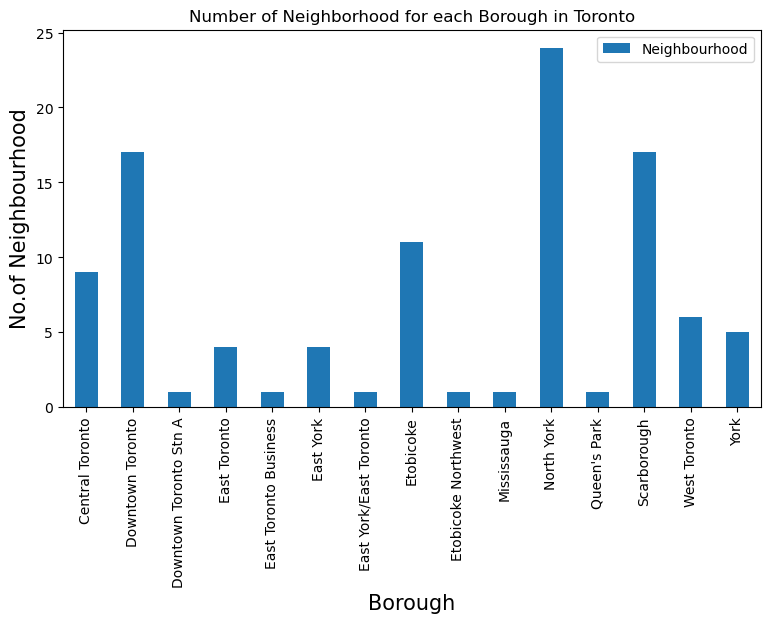

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a bar plot
toronto.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

FourSquare API credentials that will be utilised later to get venue details

In [8]:
# Hidden

We define a function to intract with FourSquare API and get top 200 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [9]:
def get_venues(lat,lng):

    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count, rating, tip counts for a given venue id. This will be used for ranking.

In [10]:
def get_venue_details(venue_id):
            
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            client_id, 
            client_secret, 
            version)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Next we will collect Indian resturants for each of 103 Neighborhoods.

In [11]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name']
indian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in toronto.values.tolist():
    PostalCode, Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(toronto),')','Indian Resturants in '+Neighbourhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_toronto = indian_rest_toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Resturants in Parkwoods, North York:0
( 2 / 103 ) Indian Resturants in Victoria Village, North York:0
( 3 / 103 ) Indian Resturants in Regent Park, Harbourfront, Downtown Toronto:2
( 4 / 103 ) Indian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Indian Resturants in Ontario Provincial Government, Queen's Park:1
( 6 / 103 ) Indian Resturants in Islington Avenue, Etobicoke:0
( 7 / 103 ) Indian Resturants in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Indian Resturants in Don Mills, North York:0
( 9 / 103 ) Indian Resturants in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Indian Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Indian Resturants in Glencairn, North York:0
( 12 / 103 ) Indian Resturants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Indian Resturants in Rouge Hill, Port Union, Highland Creek, Scarborough:0
( 14 / 103 ) Indian Resturants in Don

In [12]:
indian_rest_toronto

,Borough,Neighbourhood,ID,Name
0,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace
1,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas
2,Queen's Park,Ontario Provincial Government,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
3,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
4,Scarborough,Woburn,4c632edeedd320a19ad5ae29,Bombay Palace
5,East York,Leaside,504bcf32e4b0ef19b0e2ecf8,Mt Everest Restaurant
6,Downtown Toronto,Christie,4adb969ef964a520332921e3,Banjara Indian Cuisine
7,Downtown Toronto,Christie,4b7369d7f964a52049ad2de3,Madras Masala
8,Scarborough,Cedarbrae,4d6008f829ef236a8832a059,CANBE Foods Inc
9,Scarborough,Cedarbrae,4c77fc87bd346dcb8c90f0ef,La Sani Grill


Now let's create a bar plot to show Number of Indian Restaurants for each Borough in Toronto.

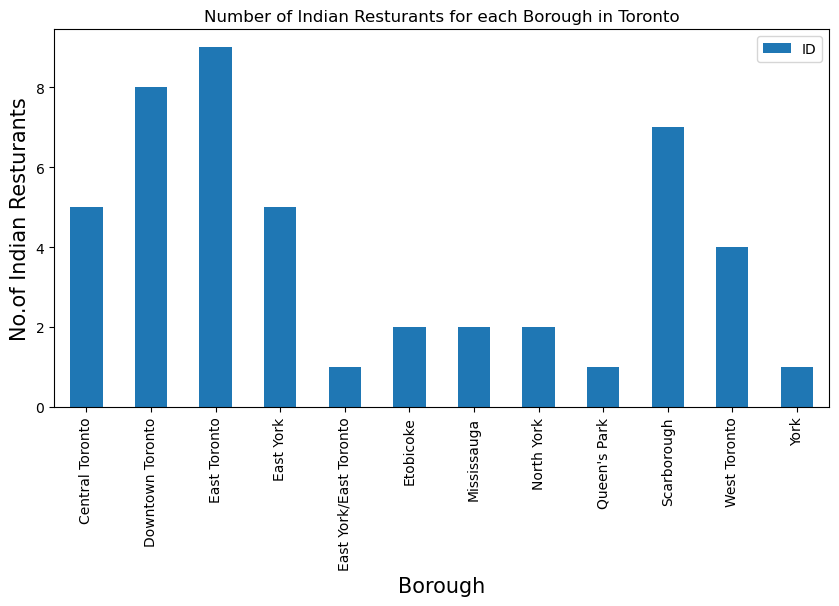

In [13]:

plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### - We can see from the Bar Plot that Borough - East Toronto has 9 Indian restaurants, which is the highest among all the boroughs.

Now, we create a bar plot that shows the top 5 neighborhoods that have higher number of Indian restaurants than any other restaurants in Toronto. 

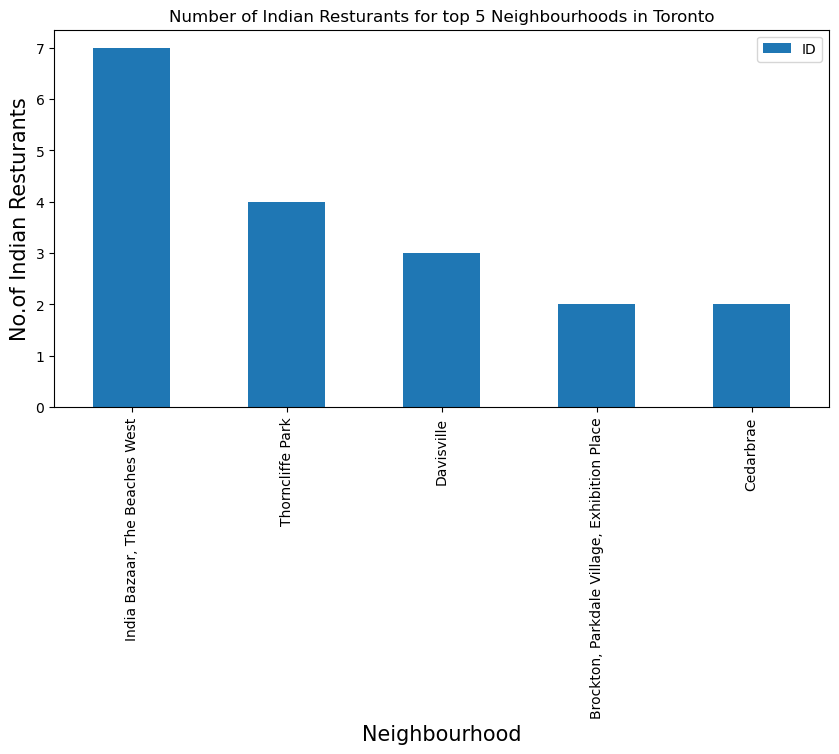

In [14]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for top 5 Neighbourhoods in Toronto')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_toronto.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### - We can see from the bar plot, 'India Bazaar, The Beaches West' neighborhood has the highest number of Indian restaurants (7) in Toronto than any other neighborhoods in Toronto.

Now we filter out the list of the Indian restaurants in 'India Bazaar, The Beaches West' neighborhood...

In [52]:
indian_rest_toronto[indian_rest_toronto['Neighbourhood']=='India Bazaar, The Beaches West']

,Borough,Neighbourhood,ID,Name
19,East Toronto,"India Bazaar, The Beaches West",4ae0c7a8f964a520638221e3,Udupi Palace
20,East Toronto,"India Bazaar, The Beaches West",4afc9816f964a520312422e3,Motimahal
21,East Toronto,"India Bazaar, The Beaches West",4bac30a2f964a52018ea3ae3,Bombay Chowpatty
22,East Toronto,"India Bazaar, The Beaches West",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
23,East Toronto,"India Bazaar, The Beaches West",4d8d278a1d06b1f712942a3b,Gautama
24,East Toronto,"India Bazaar, The Beaches West",4ae4c793f964a5201b9e21e3,The Famous Indian Restaurant
25,East Toronto,"India Bazaar, The Beaches West",4edd30c09adfe5cbe2818dc4,Lahori Taste & Burger House


Now we use the function to get venue details such as ID, Likes, Rating, Tips for Indian restaurants in Toronto and create a dataframe that contains all the data in organized manner.

In [16]:
# List of neighbourhood that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_toronto=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_toronto.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_toronto),')','processed')
    indian_rest_stats_toronto = indian_rest_stats_toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4af9a379f964a520c91222e3  Bombay Palace     14     7.1    13
( 1 / 47 ) processed
                         ID               Name  Likes  Rating  Tips
0  52af6dc5498e33995b0bbf03  Sultan Of Samosas      9     6.7     4
( 2 / 47 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4bedf8b5e24d20a17b567214  Kothur Indian Cuisine     16     8.0    19
( 3 / 47 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     6.9     3
( 4 / 47 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
( 5 / 47 ) processed
                         ID                   Name  Likes  Rating  Tips
0  504bcf32e4b0ef19b0e2ecf8  Mt Everest Restaurant      8     6.4     6
( 6 / 47 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4a

In [17]:
indian_rest_stats_toronto.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace,14,7.1,13
1,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,6.7,4
2,Queen's Park,Ontario Provincial Government,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.0,19
3,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3
4,Scarborough,Woburn,0,0,0,0.0,0


In [18]:
indian_rest_stats_toronto.shape

(47, 7)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [19]:
indian_rest_stats_toronto.to_csv('indian_rest_stats_toronto.csv', index=False)

In [20]:
indian_rest_stats_toronto_csv=pd.read_csv('indian_rest_stats_toronto.csv')
indian_rest_stats_toronto_csv.shape

(47, 7)

Lets verify the data from saved csv file.

In [21]:
indian_rest_stats_toronto_csv.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace,14,7.1,13
1,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,6.7,4
2,Queen's Park,Ontario Provincial Government,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.0,19
3,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3
4,Scarborough,Woburn,0,0,0,0.0,0


In [22]:
indian_rest_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Borough        47 non-null     object 
 1   Neighbourhood  47 non-null     object 
 2   ID             47 non-null     object 
 3   Name           47 non-null     object 
 4   Likes          47 non-null     object 
 5   Rating         47 non-null     float64
 6   Tips           47 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.7+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [23]:
indian_rest_stats_toronto['Likes']=indian_rest_stats_toronto['Likes'].astype('float64')
indian_rest_stats_toronto['Tips']=indian_rest_stats_toronto['Tips'].astype('float64')

#### Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [25]:
# Resturant with maximum Likes
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Likes'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood                    Christie
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                               142.0
Rating                                8.8
Tips                                 75.0
Name: 6, dtype: object

#### - Indian restaurant with maximum likes: Banjara Indian Cuisine

In [26]:
# Resturant with maximum Rating
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Rating'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood                    Christie
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                               142.0
Rating                                8.8
Tips                                 75.0
Name: 6, dtype: object

#### - Indian restaurant with maximu rating: Banjara Indian Cuisine

In [27]:

# Resturant with maximum Tips
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Tips'].idxmax()]

Borough                  Downtown Toronto
Neighbourhood                    Christie
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                               142.0
Rating                                8.8
Tips                                 75.0
Name: 6, dtype: object

#### - Indian restaurant with maximum tips: Banjara Indian Cuisine
#### We can see from our analysis, that 'Banjara Indian Cuisine', which is located in Downtown, Toronto is the restaurant that has the highest ratings, highest number of likes and Tips. 

In [28]:
toronto_neighbourhood_stats=indian_rest_stats_toronto.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
toronto_neighbourhood_stats.columns=['Neighbourhood','Average Rating']

Now, let's prepare a list of top 10 neighborhoods that have highest average ratings of Indian restaurants. 

In [29]:

toronto_neighbourhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
20,"The Annex, North Midtown, Yorkville",8.400000
4,Christie,8.300000
11,"High Park, The Junction South",8.300000
5,Church and Wellesley,8.050000
15,Ontario Provincial Government,8.000000
26,"Wexford, Maryvale",8.000000
2,"Brockton, Parkdale Village, Exhibition Place",7.950000
19,"St. James Town, Cabbagetown",7.900000
6,Davisville,7.333333
10,"Harbourfront East, Union Station, Toronto Islands",7.300000


In [30]:
toronto_borough_stats=indian_rest_stats_toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

Similarly we will find the average rating of Indian Resturants for each Borough.

In [31]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
8,Queen's Park,8.0000
10,West Toronto,7.8000
1,Downtown Toronto,7.7125
0,Central Toronto,7.4600
5,Etobicoke,6.9500


#### We can see that 'Queen Park' is the borough with highest average rating of Indian restaurants.


Now let's create a bar plot that shows the average rating of Indian restaurants in each borough ofToronto.

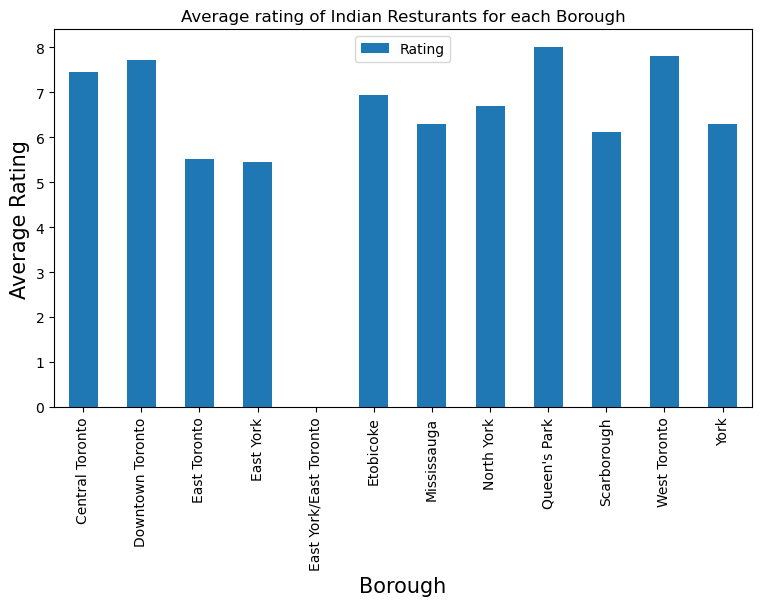

In [32]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_toronto.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Conclusion:

### From our analysis, we can answer the questions that were asked in the beginning.

#### 1. 'Banjara Indian Cuisine' is the best choice if you are looking for the best Indian food in Toronto as it has the highest rating, highest number of likes and tips among all the restaurants in Toronto. This restaurant is located in Christie neighborhood which is in Downtown Toronto.
#### 2. 'India Bazaar, The Beaches West' neighborhood has the highest number of Indian restaurants (7) in Toronto than any other neighborhoods in Toronto.
#### 3. East Toronto has 9 Indian restaurants, which is the highest among all the boroughs. However, it is the borough with least avearge rating of Indian restaurants in Toronto.
#### 4. The Annex, North Midtown, Yorkville, Christie, High Park, The Junction South are the top 5 neighborhoods that you would want to go if you are looking for best restaurants in Toronto to eat Indian food.
#### 5.  Queen's Park, West Toronto,Downtown Toronto are the top 3 boroughs for average rating of Indian restaurants.